# Git Commands

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Git/subtitle-timer

/content/drive/MyDrive/Colab Notebooks/Git/subtitle-timer


In [ ]:
!git config --global user.name "NiktinAndrei"
!git config --global user.email "1andrewnikitinn@gmail.com"

In [4]:
!git status

Refresh index: 100% (24/24), done.
On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   mask.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	__pycache__/

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git restore --staged __pycache__/augmentation.cpython-38.pyc

In [ ]:
!git add .

In [ ]:
!git commit -m "a little bit of cleaning"

[master 609d6a4] a little bit of cleaning
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite mask.ipynb (95%)


In [ ]:
!git restore augmentation.py

In [ ]:
!git push

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.62 KiB | 151.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/NikitinAndrei/subtitle-timer
   f5035d1..609d6a4  master -> master


# Используемые библиотеки

In [ ]:
import librosa as lr
import pandas as pd
import numpy as np
import os
import soundfile as sf
import keras
import random
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt


from keras.layers.convolutional import Conv1DTranspose
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Multiply, Activation
from keras.layers import Dense, GlobalAveragePooling1D, Dropout, UpSampling1D, Conv1D, MaxPooling1D, Conv2D, UpSampling2D, MaxPooling2D
from keras.layers.normalization.batch_normalization import BatchNormalization
from sklearn.model_selection import train_test_split



# Подготовка функций

In [ ]:
from augmentation import code_markers, move_audio, move_db, decode_markers, ohe, keras_generator



[0.0, 6.0, 1, 11.0, 12.0, 1]


In [ ]:
%ls

augmentation.py   Database.csv  README.md      Subsnaudios/
database_card.md  mask.ipynb    srt-to-csv.py


In [ ]:
x_train, y_train = keras_generator(train_df, len(list(train_df.index)) , t, sr=sr,
                                   path='drive/MyDrive/Mono/')

# # # x_val, y_val = keras_generator(val_df, len(list(val_df.index)) , t, sr=sr, 
# # #                                path='drive/MyDrive/Mono/')

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  # random_state=0,
                                                  shuffle=False)

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_coef2(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

def dice_loss(y_true, y_pred, smooth=1e-6):
    """ Loss function base on dice coefficient.
    Parameters
    ----------
    y_true : keras tensor
        tensor containing target mask.
    y_pred : keras tensor
        tensor containing predicted mask.
    smooth : float
        small real value used for avoiding division by zero error.
    Returns
    -------
    keras tensor
        tensor containing dice loss.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    answer = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. -answer

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'bce_dice_loss': bce_dice_loss })
get_custom_objects().update({'dice_loss': dice_loss })
get_custom_objects().update({'dice_coef': dice_coef })
get_custom_objects().update({'my_iou_metric': my_iou_metric })

In [ ]:
inp = Input(shape=(duration, 1))
neur = 16
size = 9
# Block 1
x = Conv1D(neur, size, padding='same', name='block1_conv1')(inp)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(neur, size, padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
block_1_out = Activation('relu')(x)
x = MaxPooling1D()(block_1_out)
# Block 2
x = Conv1D(neur*2, size, padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(128, (3), padding='same', name='block2_conv2')(x)
# x = BatchNormalization()(x)
block_2_out = Activation('relu')(x)
x = MaxPooling1D()(block_2_out)
# Block 3
x = Conv1D(neur*(2**2), (size), padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(neur*(2**2), 3, padding='same', name='block3_conv2')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)
# x = BatchNormalization()(x)
block_3_out = Activation('relu')(x)
x = MaxPooling1D()(block_3_out)
# Block 4
x = Conv1D(neur*(2**3), size, padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(neur*(2**3), 3, padding='same', name='block4_conv2')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)
# x = BatchNormalization()(x)
block_4_out = Activation('relu')(x)
x = MaxPooling1D()(block_4_out)
# Block 5
x = Conv1D(neur*(2**4), size, padding='same', name='block5_conv1')(x)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(neur*(2**4), 3, padding='same', name='block5_conv2')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(1024, 3, padding='same', name='block5_conv3')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
block_5_out = Activation('relu')(x)
x = MaxPooling1D()(block_5_out)

# Block 6
x = Conv1D(neur*(2**5), size, padding='same', name='block6_conv1')(x)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(neur*(2**5), 3, padding='same', name='block6_conv2')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(2048, 3, padding='same', name='block6_conv3')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
block_6_out = Activation('relu')(x)
x = MaxPooling1D()(block_6_out)

# # Block 7
x = Conv1D(neur*(2**5), size, padding='same', name='block7_conv1')(x)
x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(neur*(2**5), 3, padding='same', name='block7_conv2')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Conv1D(4096, 3, padding='same', name='block7_conv3')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
block_7_out = Activation('relu')(x)
x = MaxPooling1D()(block_7_out)

# Block 8
x = Conv1D(neur*(2**5), size, padding='same', name='block8_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Conv1D(neur*(2**5), 3, padding='same', name='block8_conv2')(x)
# x = BatchNormalization()(x)
# block_8_out = Activation('relu')(x)
# x = MaxPooling1D()(block_8_out)

# # Block 9
# x = Conv1D(neur*(2**5), 3, padding='same', name='block9_conv1')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# # x = Conv1D(neur*(2**5), 3, padding='same', name='block9_conv2')(x)
# # x = BatchNormalization()(x)
# # block_9_out = Activation('relu')(x)
# # x = MaxPooling1D()(block_9_out)

# # # Block 10
# # x = Conv1D(neur*(2**5), 3, padding='same', name='block10_conv1')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = Conv1D(neur*(2**5), 3, padding='same', name='block10_conv2')(x)
# # x = BatchNormalization()(x)
# # block_10_out = Activation('relu')(x)
# # x = MaxPooling1D()(block_10_out)

# # # Block 11
# # x = Conv1D(neur*(2**5), 3, padding='same', name='block11_conv1')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # # block_11_out = Activation('relu')(x)
# # # x = MaxPooling1D()(block_11_out)

# # # # Block 12
# # # x = Conv1D(neur*(2**8), 3, padding='same', name='block12_conv1')(x)
# # # x = BatchNormalization()(x)
# # # x = Activation('relu')(x)
# # # block_12_out = Activation('relu')(x)
# # # x = MaxPooling1D()(block_12_out)

# # # # Block 13
# # # x = Conv1D(neur*(2**8), 3, padding='same', name='block13_conv1')(x)
# # # x = BatchNormalization()(x)
# # # x = Activation('relu')(x)

# # # # UP -7
# # # x = Conv1DTranspose(neur*(2**8), 3, strides=2, padding='same')(x)
# # # x = Dropout(0.5)(x)
# # # x = BatchNormalization()(x)
# # # x = Activation('relu')(x)
# # # x = Concatenate()([x, block_12_out])

# # # # UP -6
# # # x = Conv1DTranspose(neur*(2**8), 3, strides=2, padding='same')(x)
# # # x = Dropout(0.5)(x)
# # # x = BatchNormalization()(x)
# # # x = Activation('relu')(x)
# # # x = Concatenate()([x, block_11_out])

# # # UP -10
# # x = Conv1DTranspose(neur*(2**5), 3, strides=2, padding='same')(x)
# # x = Dropout(0.5)(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = Concatenate()([x, block_10_out])
# # x = Conv1D(2048, 3, padding='same')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)

# # # UP -9
# # x = Conv1DTranspose(neur*(2**5), 3, strides=2, padding='same')(x)
# # x = Dropout(0.5)(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = Concatenate()([x, block_9_out])
# # x = Conv1D(2048, 3, padding='same')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)

# # UP -8
# x = Conv1DTranspose(neur*(2**5), 3, strides=2, padding='same')(x)
# x = Dropout(0.5)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Concatenate()([x, block_8_out])
# x = Conv1D(2048, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# UP -7
x = Conv1DTranspose(neur*(2**5), size, strides=2, padding='same')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_7_out])
x = Conv1D(neur*(2**5), size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# UP -6
x = Conv1DTranspose(neur*(2**5), size, strides=2, padding='same')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_6_out])
x = Conv1D(neur*(2**5), 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Conv1D(2048, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# UP -5
x = Conv1DTranspose(neur*(2**5), size, strides=2, padding='same')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_5_out])
x = Conv1D(neur*(2**5), 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Conv1D(1024, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# UP -4
x = Conv1DTranspose(neur*(2**4), size, strides=2, padding='same', name='conv1dT')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_4_out])
x = Conv1D(neur*(2**4), size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Conv1D(512, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# UP -3
x = Conv1DTranspose(neur*(2**3), size, strides=2, padding='same', name = 'Conv1DTranspose_UP2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_3_out])
x = Conv1D(neur*(2**3), size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Conv1D(256, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# UP -2
x = Conv1DTranspose(neur*(2**2), size, strides=2, padding='same', name = 'Conv1DTranspose_UP3')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_2_out])
x = Conv1D(neur*(2**2), size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Conv1D(128, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# UP -1
x = Conv1DTranspose(neur*(2**1), (size), strides=(2), padding='same', name = 'Conv1DTranspose_UP4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_1_out])
x = Conv1D(neur*(2**1), size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Conv1D(64, (3), padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# Final
x = Conv1D(3, 1, activation='softmax', padding='same')(x)
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model = Model(inp, x)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=[dice_coef2])


In [ ]:
best_w = keras.callbacks.ModelCheckpoint('unet_bestv3.h5',
                                monitor='val_loss',
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                )

last_w = keras.callbacks.ModelCheckpoint('unet_lastv3.h5',
                                monitor='loss',
                               
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                )


In [ ]:
# model.summary()

In [ ]:
# model.fit(x_train,y_train,
#           epochs=9,
#           validation_data=(x_val,y_val),
#           batch_size=3,
#           callbacks = [best_w, last_w])

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('drive/MyDrive/Models/unet_bestv3_2.h5', custom_objects={'dice_coef2': dice_coef2})
# model = load_model('unet_bestv3.h5', custom_objects={'dice_coef2': dice_coef2})

markers = '0.382, 1.650, 1, 2.016, 3.814, 2, 4.423, 5.830, 1, 6.416, 7.880, 2, 8.725, 9.848, 1, 10.710, 11.995, 2, 13.027, 14.646, 1, 15.589, 16.955, 2, 17.939, 19.403, 1, 20.655, 22.220, 2, 23.453, 25.055, 1, 26.161, 27.397, 2, 28.609, 30.072, 1, 31.048, 32.350, 2, 33.415, 34.496, 1, 35.407, 36.538, 2, 37.733, 38.717, 1, 39.555, 40.620, 2, 41.563, 42.799, 1, 43.523, 44.532, 2'

sr = 16000 
t = 8

def pred_audio(audio:str, sr=sr, t=t):
  
  a, sr = lr.load(audio, sr)
  a = np.array(a)

  # Оригинальный рисунок
  
  a = a/np.amax(abs(a))
  res = np.array([])
  if a.shape[0] > sr*t:
    n = a.shape[0]//(sr*t)
    
    n += 1
    z = n * sr * t - a.shape[0]
    z = np.zeros(z)
    a = np.hstack((a, z))

    
    
    cont = [np.zeros(sr*t) for i in range(n)]
    cont = np.array(cont)
    
    for i in range(n):
      cont[i][:] = a[i*sr*t:(i + 1)*sr*t]
    cont = np.expand_dims(cont, -1)
    
    y = model.predict(cont)

    coded = np.array([])
    for i in range(y.shape[0]):
      
        temp = (np.zeros(y.shape[1]))
        temp[:] = np.argmax(y[i], axis=1)
        coded = np.hstack((coded, temp))
    return coded


coded_2 = pred_audio('drive/MyDrive/Mono/Train 18.WAV')  



In [ ]:
audio, sr = lr.load('drive/MyDrive/Mono/Train 18.WAV', sr)

plt.figure(figsize=(15,7))
plt.plot(np.arange(audio.shape[0]), audio)
plt.savefig('audio.png')
plt.clf()

<Figure size 1080x504 with 0 Axes>

66.18815104166667
90.41770833333334


<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

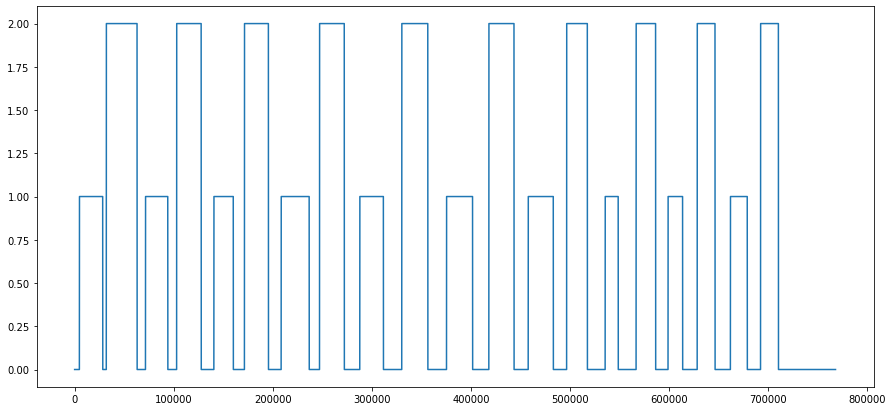

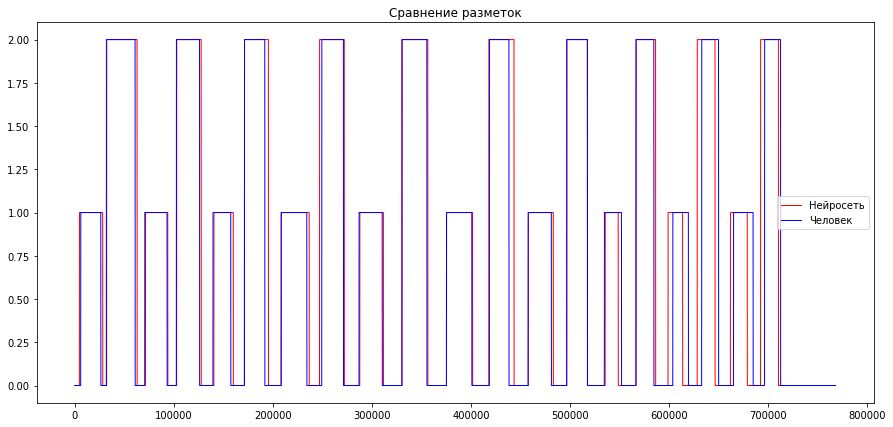

In [ ]:
coded = np.copy(coded_2)

mask = decode_markers(markers)
mask = np.hstack((mask, np.zeros(coded.shape[0] - mask.shape[0])))
count = 0

flag = 0
start = 0

plt.figure(figsize=(15,7))
plt.plot(np.arange(coded.shape[0]), coded)
plt.savefig('pre.png')
plt.clf()


for i,num in enumerate(coded):
    if num==2:
        coded[i]=0
    elif num==0:
        coded[i]=2
    elif num==1:
        coded[i]=0


# Убираем вначале
coded[0:int(0.3*sr)]=np.zeros(int(0.3*sr))
# Убираем в конце
coded[int(45*sr):coded.shape[0]]=np.zeros(coded.shape[0]-int(45*sr))

plt.figure(figsize=(15,7))
plt.plot(np.arange(coded.shape[0]), coded)
plt.savefig('crop.png')
plt.clf()


coded_orig = np.copy(coded)
# Сглаживаем
step = 16
p = 0.2
thr = int(step * 0.6)
i = 0


while i < (coded.shape[0] - step):
    j = 0
    l = coded[i:i+step]
    l = l.tolist()
    none = l.count(0)
    inh = l.count(1)
    exh = l.count(2)
    
    if none >= thr:
        coded[i:i+step] = [0 for j in range(step)]
        
    if inh >= thr:
        coded[i:i+step] = [1 for j in range(step)]

    if exh >= thr:
        coded[i:i+step] = [2 for j in range(step)]

    i += step


coded_smooth = np.copy(coded)
coded[int(3.9375*sr):int(4.46875 * sr)] = np.ones(int(4.46875*sr-3.9375*sr))*0
coded[int(34.496*sr):int(35.407 * sr)] = np.ones(int(35.407*sr-34.496*sr))*0

# for i in range(len(coded)-2):
#     if coded[i] == 0 and coded[i + 1] == 1 and flag != 1:
#         flag = 1
#         start = i
        
#     if coded[i] == 0 and coded[i + 1] == 1 and flag == 1:
#         coded[start:i] = [1 for j in range(i - start)]
#         flag = 0
#         if coded[i+2] == 1:
#             flag = 1
            
#     if coded[i] == 0 and coded[i + 1] == 2 and flag != 2 :
#         flag = 2
#         start = i

#     if coded[i] == 0 and coded[i + 1] == 1 and flag == 2:
#         coded[start:i] = [2 for j in range(i - start)]
#         flag = 0
#         if coded[i+2] == 2:
#             flag = 2
count = 0
for i in range(0,coded.shape[0]):
    if coded[i]==mask[i]:
        count += 1
perc = count/(coded.shape[0])*100 
print(perc)

flag_0 = False
flag_2 = False

coded[0] = 0

# for i in range(len(coded)-2):
    

    # if coded[i] == 0 and flag_0 == False and flag_2 == False:
    #     flag_0 = True
    
    # if coded[i] == 2 and flag_2 == False and flag_0 == True:
    #     flag_2 = True

    # if flag_0 == True and flag_2 == True and coded[i] == 2:
    #     coded[i] = 1

    # if flag_2 == True and flag_0 == True and coded[i] == 0:
    #     flag_0 = False
    #     flag_2 = False
    # if flag_0 == False and flag_2 == True and coded[i] != 2:
    #     flag_2 = False
    
    # if coded[i] == 0 and coded[i+1] != 0 and flag == False:
    #     flag = True

    # if flag==True and coded[i]==0 and coded[i+1] != 0:
    #     flag=False

    # if flag == True and coded[i] == 2:
    #     coded[i] = 1


coded_1 = np.copy(coded) 

start = 0 
finish = 0

# Artefacts
i = 0

while i < coded.shape[0]-1:

    if coded[i] == 2 and coded[i+1] == 0:
        start = i
    if coded[i] == 0 and coded[i+1] == 2:
        finish  = i
        if finish - start < int(p * sr):
            coded[start:finish+1] = np.ones(finish - start+1) * 2
            start, finish = 0, 0
        else: start,finish = 0, 0
    i += 1

while i < coded.shape[0]-1:

    if coded[i] == 0 and coded[i+1] == 2:
        start = i
    if coded[i] == 2 and coded[i+1] == 0:
        finish  = i
        if finish - start < int(p * sr):
            coded[start:finish+1] = np.ones(finish - start+1) * 0
            start, finish = 0, 0
        else: start,finish = 0, 0
    i += 1


coded_arts = np.copy(coded)

# flag = False

# 1 и 2
for i in range(0,coded.shape[0]-1):
    if coded[i] == 0 and coded[i+1] != 0 and flag == False:
        flag = True
        
    elif flag==True and coded[i]==0 and coded[i+1] != 0:
        flag=False
        

    if flag == True and coded[i] != 0:
        coded[i] = 1

for i in range(coded.shape[0]):
    if coded[i] != 0:
        coded_orig[i] = coded[i] * coded_orig[i]
        coded_smooth[i] = coded[i] * coded_smooth[i]
        coded_arts[i] = coded[i] * coded_arts[i]

coded_orig = coded_orig/2
coded_smooth = coded_smooth/2
coded_arts = coded_arts/2

# for i in range(coded.shape[0]):
#     if coded_orig[i] != 1:
#         coded_orig = coded_orig/2
#     if coded_smooth[i] != 1:
#         coded_smooth = coded_smooth/2
#     if coded_arts[i] != 1:
#         coded_smooth = coded_smooth/2

plt.figure(figsize=(15,7))
plt.plot(np.arange(coded.shape[0]), coded_orig)
plt.savefig('original.png')
plt.clf()
plt.plot(np.arange(coded.shape[0]), coded_smooth)
plt.savefig('smooth.png')
plt.clf()
plt.plot(np.arange(coded.shape[0]), coded_arts)
plt.savefig('artefs.png')

x = np.arange(coded.shape[0])
plt.figure(figsize=(15,7))
plt.plot(x, coded, 'r', linewidth=1, label='Нейросеть')
plt.plot(x, mask, 'b', linewidth=1, label='Человек')
plt.title('Сравнение разметок')
plt.legend()
plt.savefig('compare.png')

count = 0
for i in range(0,coded.shape[0]):
    if coded[i]==mask[i]:
        count += 1
perc = count/(coded.shape[0]) * 100 
print(perc)

    
   
    # 3 512 3
#     # !!!
#       temp[:] = np.argmax(y[i], axis=1)
#       coded = code_markers(coded, sr)
    
#     print(coded)
#       # res = np.hstack((res, y))
#     # print(res[1][0:200])
#   # print(cont[1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


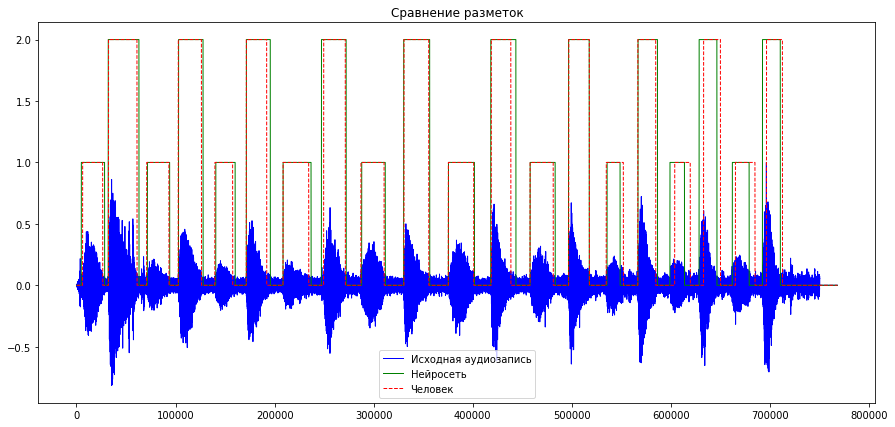

In [ ]:
test = coded
mask = decode_markers(markers, sr=sr)
n = test.shape[0]//(sr * t)
mask = np.hstack((mask, np.zeros(n*sr*t - mask.shape[0])))
audio = np.hstack((audio, np.zeros(768000-audio.shape[0])))
audio = audio/np.amax(audio)
x = np.arange(coded.shape[0])
plt.figure(figsize=(15,7))
plt. plot(x, audio, 'b', linewidth=1, label='Исходная аудиозапись')
plt.plot(x, coded, 'g', linewidth=1, label='Нейросеть')
plt.plot(x, mask, 'r--', linewidth=1, label='Человек')
plt.title('Сравнение разметок')
plt.legend()
plt.savefig('compare.png')

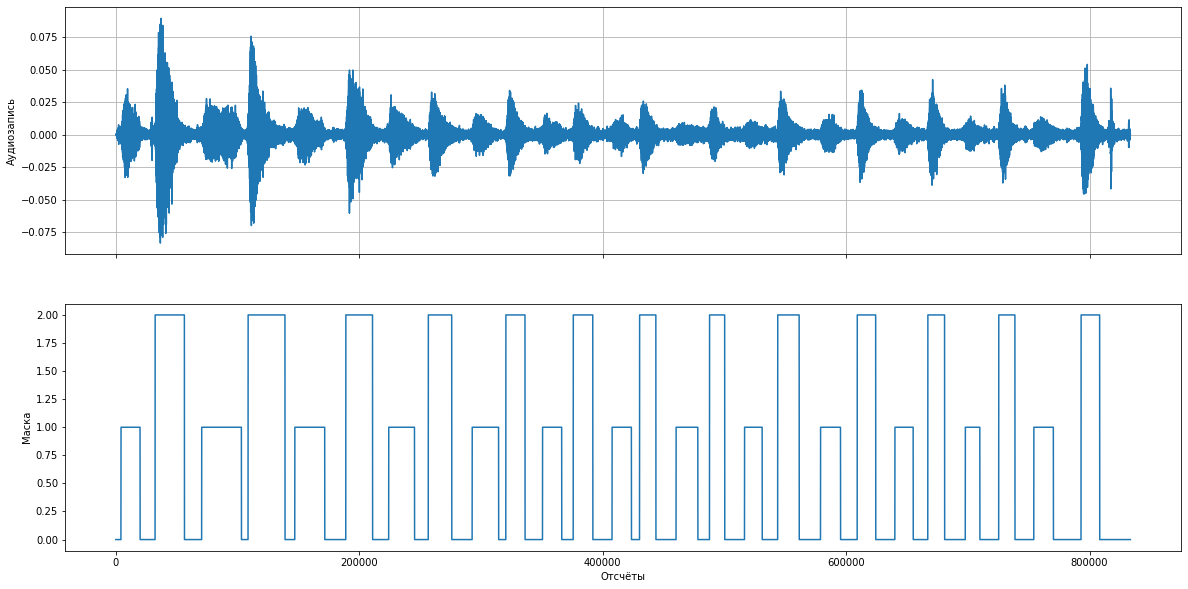

In [ ]:
df = pd.read_csv('Db+1.345+2.1.csv')
path='drive/MyDrive/Mono/'
nomer = 8
audio,sr = lr.load(path + df.loc[nomer, 'Name'], sr)
audio = np.array(audio)
x = np.arange(audio.shape[0])
markers = decode_markers(df.loc[nomer, 'Markers'])
markers = np.hstack((markers, np.zeros(audio.shape[0] - markers.shape[0])))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20,10))
axs[0].plot(x, audio)

axs[0].set_ylabel('Аудиозапись')
axs[0].grid(True)

axs[1].plot(x, markers)
axs[1].set_ylabel('Маска')
axs[1].set_xlabel('Отсчёты')

# fig.tight_layout()
plt.savefig('pic_1.png')
plt.show()

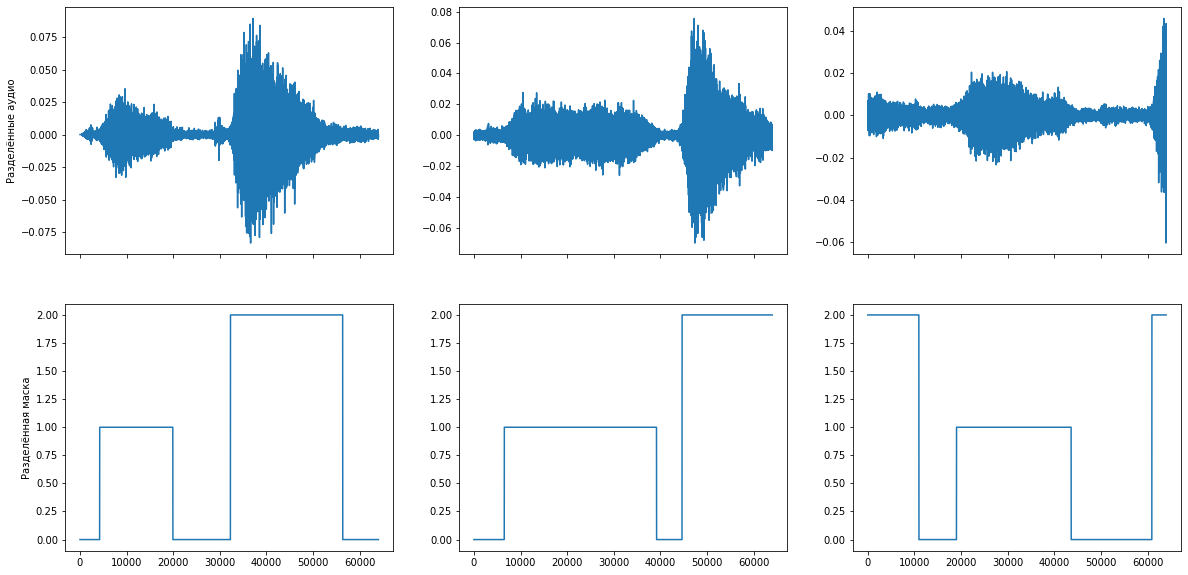

In [ ]:
audio_1 = audio[0:sr*t]
audio_2 = audio[sr*t : 2*sr*t]
audio_3 = audio[2*sr*t : 3*sr*t]

markers_1 = markers[0:sr*t]
markers_2 = markers[sr*t : 2*sr*t]
markers_3 = markers[2*sr*t : 3*sr*t]

x = np.arange(sr*t)

fig, axs = plt.subplots(2, 3, sharex=True, figsize=(20,10))
axs[0, 0].plot(x, audio_1)
axs[0, 0].set_ylabel('Разделённые аудио')
axs[0, 1].plot(x, audio_2)
axs[0, 2].plot(x, audio_3)

axs[1, 0].plot(x, markers_1)
axs[1, 0].set_ylabel('Разделённая маска')
axs[1, 1].plot(x, markers_2)
axs[1, 2].plot(x, markers_3)



# fig.tight_layout()
plt.savefig('pic_2.png')
plt.show()

In [ ]:
count = 0
for i in range(0,test.shape[0]):
    if coded[i]==mask[i]:
        count += 1
perc = count/(n * sr * t)*100 
print('Результат алгоритма', code_markers(test, sr))
print('Первоначальная разметка', markers)
print('Процент совпавших меток =', perc)

Результат алгоритма [0.4375, 1.71875, 1, 2.03125, 3.9375, 2, 4.46875, 5.8125, 1, 6.46875, 7.96875, 2, 8.875, 9.875, 1, 10.71875, 12.03125, 2, 13.09375, 14.75, 1, 15.625, 16.90625, 2, 18.03125, 19.40625, 1, 20.65625, 22.125, 2, 23.59375, 25.0, 1, 26.15625, 27.53125, 2, 28.6875, 30.0, 1, 31.0625, 32.25, 2, 33.5, 34.25, 1, 35.4375, 36.46875, 2, 37.53125, 38.3125, 1, 39.28125, 40.28125, 2, 41.40625, 42.40625, 1, 43.3125, 44.34375, 2]
Первоначальная разметка 0.382, 1.650, 1, 2.016, 3.814, 2, 4.423, 5.830, 1, 6.416, 7.880, 2, 8.725, 9.848, 1, 10.710, 11.995, 2, 13.027, 14.646, 1, 15.589, 16.955, 2, 17.939, 19.403, 1, 20.655, 22.220, 2, 23.453, 25.055, 1, 26.161, 27.397, 2, 28.609, 30.072, 1, 31.048, 32.350, 2, 33.415, 34.496, 1, 35.407, 36.538, 2, 37.733, 38.717, 1, 39.555, 40.620, 2, 41.563, 42.799, 1, 43.523, 44.532, 2
Процент совпавших меток = 90.97942708333333


# Конец

In [ ]:
del list

In [ ]:
from tensorflow.keras.models import load_model

def pred_audio(audio:str, sr=sr, t=t):
  a, sr = lr.load(audio, sr)
  a = np.array(a)
  a = a/np.amax(abs(a))
  print(a.shape)
  if a.shape[0] < sr*t:
    n = a/(sr*t)
    n = int(n) + 1
    containers = [np.zeros(sr*t) for i in range(n)]
    print(containers.shape)

pred_audio('drive/MyDrive/Mono/Train 16(edit).WAV')
# if a.shape[0] < sr*t:
#   z = np.zeros(sr*t - a.shape[0])
#   a = np.hstack((a,z))
# else: a = a[:sr*t] 

# print(a.shape)
# a = a.reshape(1,sr*t,1)

# model = load_model('unet_best.h5')
# y = model.predict(a)
# print(y.shape)
# # print(y[0][308:508])
# # print(np.argmax(y[0][573]))

# def predToAudio(segment):
#   aud = segment[0]
#   aud = np.zeros((segment.shape[1], 1))
#   aud[:, 0] = (np.argmax(segment, axis=2))
#   return aud.astype('uint8')
# aud =  np.array(predToAudio(y))
# print(aud.shape)
# y = code_markers(aud, sr)
# print(y)
# # y = np.around(y, 4)
# # y = y.reshape(sr*t)
# # for i in range(len(y)):
# #   if y[i] > np.mean(y):
# #     y[i] = 1
# #   elif y[i] < np.mean(y): y[i] = 0
# # print(y)
# # y = code_markers(y, sr)
# # print(y)
# # print(y, df.loc[1, 'Markers'])


(1030802,)


In [ ]:
def decode_breath(dSet):
  out = []
  for i in range(dSet.shape[0]):# проходимся по загруженной выборке
    for j in range(dSet.shape[1]):
      out.append(np.argmax([dSet[i][j]]))  
    
  out = np.array(out)
  
  return out